<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/10_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подгружаем необходимые библиотеки 

In [111]:
import numpy as np
import pandas as pd

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [113]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

Подгружаем данные из SDSS обзора, которые были получены: http://skyserver.sdss.org/CasJobs/mydbcontent.aspx?ObjName=SpecPhotoAll&ObjType=TABLE&context=DR16&type=normal 

Здесь уже выполнены следующие преобразования:

1) Удалены строчки с разряженными данными (где отсутствуют интересующие нас фотометрические признаки), выбросы, удалены не интересующие нас признаки

2) Удалены дубрирующиеся данные

3) Объединены основные спектральные классы звезд 

In [176]:
df = pd.read_csv('/content/drive/MyDrive/Nauch/df_done_sub.csv') #выборка с уже объединеными подклассами звезд 
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,GALAXY,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,QSO,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,GALAXY,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,GALAXY,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,GALAXY,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [177]:
df.shape

(4614588, 17)

In [178]:
df.describe()

,objID,ra,dec,z,zErr,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
count,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06
mean,1.237665e+18,1.728012e+02,2.406577e+01,5.773699e-01,5.854844e-02,2.240051e+01,2.122111e+01,2.029666e+01,1.974275e+01,1.938488e+01,2.136179e+01,2.051423e+01,1.961589e+01,1.905677e+01,1.868825e+01
std,8.417649e+12,9.444408e+01,1.910161e+01,7.297733e-01,1.930832e+01,1.954846e+00,1.940199e+00,1.713228e+00,1.552831e+00,1.512268e+00,2.117606e+00,1.993697e+00,1.852755e+00,1.742048e+00,1.677772e+00
min,1.237646e+18,9.090791e-05,-1.970271e+01,-1.144691e-02,-6.000000e+00,6.752299e+00,7.464891e+00,8.449972e+00,7.611034e+00,6.444011e+00,1.020505e+01,1.043573e+01,1.033073e+01,1.027642e+01,8.829096e+00
25%,1.237659e+18,1.271012e+02,6.893257e+00,6.228666e-02,2.494150e-05,2.105644e+01,1.980771e+01,1.908989e+01,1.871800e+01,1.840915e+01,1.987525e+01,1.888042e+01,1.805814e+01,1.767278e+01,1.742591e+01
50%,1.237664e+18,1.741648e+02,2.352539e+01,4.268281e-01,9.249016e-05,2.259238e+01,2.147956e+01,2.063976e+01,2.007801e+01,1.967025e+01,2.116473e+01,2.097991e+01,2.011406e+01,1.942030e+01,1.898551e+01
75%,1.237668e+18,2.271129e+02,3.864779e+01,7.037950e-01,1.989703e-04,2.390630e+01,2.277750e+01,2.155568e+01,2.080758e+01,2.034762e+01,2.250614e+01,2.198993e+01,2.102539e+01,2.035791e+01,1.984414e+01
max,1.237681e+18,3.599999e+02,8.485214e+01,7.051930e+00,3.068822e+04,3.192045e+01,3.032868e+01,2.971638e+01,2.995165e+01,2.748061e+01,3.428534e+01,3.330923e+01,3.088891e+01,3.268382e+01,3.119199e+01


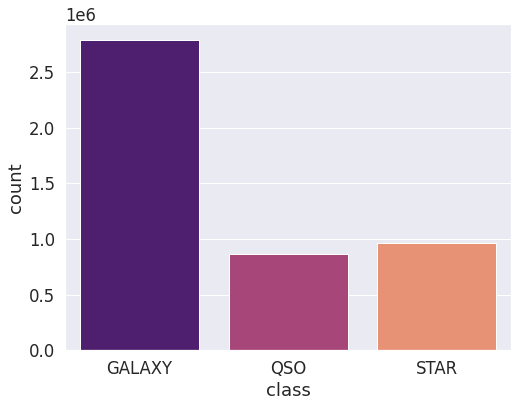

In [179]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.countplot(x=df['class'], palette = 'magma')

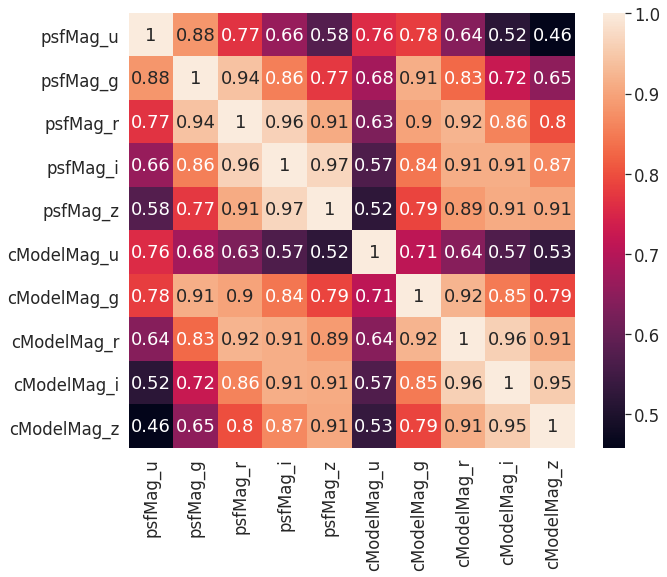

In [180]:
corr = df.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1).corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr, annot = True)

# Подготовка данных для классификатора

Классификатор звезд против галактик и квазаров 

In [181]:
df_mean = df.copy()
labels = {'STAR':0, 'GALAXY':1, 'QSO':1}
df_mean.replace({'class':labels}, inplace = True)
df_mean.head()

labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({'class':labels}, inplace = True)
c = df['class'].values


In [182]:
X_mean =  df_mean.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1).values
y_mean = df_mean['class'].values
X_mean.shape

(4614588, 10)

In [183]:
def data_preparation(X, y, c, test_size = 0.8):

    count = np.min(((y==1).sum(), (y==0).sum()))
    
    X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[c==2], y[c==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[c==3], y[c==3], test_size=test_size, random_state = 43)
    
    count = X0_train.shape[0]
    count1 = X0_test.shape[0]
    #i1 = 5
    i2 = 4
    i3 = 2
    X_train, X_test = np.concatenate((X0_train[:count], X2_train[:count//i2], X3_train[:2*count//i3])), np.concatenate((X0_test, X2_test[:count1//2], X3_test[:count1//2]))
    y_train, y_test = np.concatenate((y0_train[:count], y2_train[:count//i2], y3_train[:2*count//i3])), np.concatenate((y0_test, y2_test[:count1//2], y3_test[:count1//2]))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()

    X0_train_not_scaling = X0_train.copy()
    X2_train_not_scaling = X2_train[:count//i2].copy()
    X3_train_not_scaling = X3_train[:2*count//i3].copy() 

    X0_test_not_scaling = X0_test.copy()
    X2_test_not_scaling = np.concatenate((X2_test, X2_train[count//i2:])).copy()
    X3_test_not_scaling = np.concatenate((X3_test, X3_train[count//i3:])).copy()

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    #X1_test = robust.transform(X1_test)
    #X1_train = robust.transform(X1_train)
    X2_test = robust.transform(np.concatenate((X2_test, X2_train[count//i2:])))
    y2_test = np.concatenate((y2_test, y2_train[count//i2:]))
    X2_train = robust.transform(X2_train[:count//i2])
    y2_train = y2_train[:count//i2]
    X3_test = robust.transform(np.concatenate((X3_test, X3_train[count//i3:])))
    y3_test = np.concatenate((y3_test, y3_train[count//i3:]))
    X3_train = robust.transform(X3_train[:count//i3])
    y3_train = y3_train[:count//i3]
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test

Теперь подготовка данных для OB

Начнем с классификатора OB против Галактик и Квазаров.

In [184]:
df_g_q = df.copy()
df_g_q['ob'] = 1
df_g_q['ob'][df_g_q['subClass'] == 'OB'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [185]:
df_g_q = df_g_q[(df_g_q['class'] != 1) | (df_g_q['ob'] == 0)] #оставляе в выборке только ОВ звезды, галактики и квазары
df_g_q.shape

(3667956, 18)

In [186]:
df_g_q.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,ob
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,2,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795,1
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,3,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354,1
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,2,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257,1
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,2,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923,1
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,2,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757,1


In [187]:
X_g_q =  df_g_q.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob'], axis = 1).values
y_g_q = df_g_q['ob'].values
c_g_q = df_g_q['class'].values

In [188]:
df_g_q0 = pd.concat([df_g_q[df_g_q['ob']==0].sample(3000),  df_g_q[df_g_q['class']==2].sample(3000)])#, df_g_q[df_g_q['class']==3].sample(1000), df_g_q[df_g_q['ob']==1][df_g_q[df_g_q['ob']==1]['class']==1].sample(1000)])

In [ ]:
sns.pairplot(data = df_g_q0.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1), palette = 'Dark2', hue = 'ob')

Ниже представлена функция для разделения выборки на тестовую и обучающую с нормировкой признаков

In [189]:
def data_preparation_g_q(X, y, c, test_size = 0.2):
    count = np.min(((y==1).sum(), (y==0).sum()))
    print(count, (y==0).sum(), (y==1).sum())
    
    X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[c==2], y[c==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[c==3], y[c==3], test_size=test_size, random_state = 43)
    
    count = X0_train.shape[0]
    count1 = X0_test.shape[0]
    #i1 = 5
    i2 = 4
    i3 = 2
    X_train, X_test = np.concatenate((X0_train[:count], X2_train[:count//i2], X3_train[:2*count//i3])), np.concatenate((X0_test, X2_test[:count1//2], X3_test[:count1//2]))
    y_train, y_test = np.concatenate((y0_train[:count], y2_train[:count//i2], y3_train[:2*count//i3])), np.concatenate((y0_test, y2_test[:count1//2], y3_test[:count1//2]))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()

    X0_train_not_scaling = X0_train.copy()
    X2_train_not_scaling = X2_train[:count//i2].copy()
    X3_train_not_scaling = X3_train[:2*count//i3].copy() 

    X0_test_not_scaling = X0_test.copy()
    X2_test_not_scaling = np.concatenate((X2_test, X2_train[count//i2:])).copy()
    X3_test_not_scaling = np.concatenate((X3_test, X3_train[count//i3:])).copy()

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    #X1_test = robust.transform(X1_test)
    #X1_train = robust.transform(X1_train)
    X2_test = robust.transform(np.concatenate((X2_test, X2_train[count//i2:])))
    y2_test = np.concatenate((y2_test, y2_train[count//i2:]))
    X2_train = robust.transform(X2_train[:count//i2])
    y2_train = y2_train[:count//i2]
    X3_test = robust.transform(np.concatenate((X3_test, X3_train[count//i3:])))
    y3_test = np.concatenate((y3_test, y3_train[count//i3:]))
    X3_train = robust.transform(X3_train[:count//i3])
    y3_train = y3_train[:count//i3]
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test

Аналогично для классификации OB звезд против звезд других подклассов:

In [190]:
df_st = df.copy()
df_st['ob'] = 1
df_st['ob'][df_st['subClass'] == 'OB'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [191]:
df_st = df_st[(df_st['class'] == 1)] #оставляем в выборке только ОВ и другие звезды
df_st = df_st.drop(['class'], axis = 1)

In [192]:
X_st =  df_st.drop(['subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob'], axis = 1).values
y_st = df_st['ob'].values
X_st.shape

(960363, 10)

In [193]:
df_st0 = pd.concat([df_st[df_st['ob']==0].sample(3000),  df_st[df_st['ob']==1].sample(3000)])

In [ ]:
sns.pairplot(data = df_st0.drop(['subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1), palette = 'Dark2', hue = 'ob')

In [196]:
sub = df_st['subClass']
df_st['subClass'].unique() #Посмотрим, сколько спектраных классов (уже объединеных)

array(['F', 'G', 'WD', 'M', 'K', 'A', 'OB', 'LT', 'C'], dtype=object)

Обработка данных для классификатора (не OB строятся с одинаковым кол-вом из каждого подкласса)

In [197]:
def data_preparation_st(X, y, test_size = 0.2): #oбработка данных для классификаторов
    count = np.min(((y==1).sum(), (y==0).sum()))
    #print(count, (y==0).sum(), (y==1).sum(), X[y==0])
    
    X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=test_size, random_state = 43)
    count = (y==0).sum()
    
    countKK = 0
    for i in df_st['subClass'].unique():
      if i != 'OB':
        countKK +=1 
        ind = np.random.choice(y[sub == i].sum(), size=min(count//8, y[sub == i].sum()), replace=False)
        tr, tes, ytr, ytes = train_test_split(X[sub == i][ind], y[sub == i][ind], test_size=test_size, random_state = 43)
        if countKK == 1:
          X1_train = tr
          X1_test = tes
          y1_train = ytr
          y1_test = ytes
        else:          
          X1_train = np.concatenate((X1_train, tr))
          X1_test = np.concatenate((X1_test, tes))
          y1_train = np.concatenate((y1_train, ytr))
          y1_test = np.concatenate((y1_test, ytes))
    
    #count = X0_train.shape[0]
    #count1 = X0_test.shape[0]
    X_train, X_test = np.concatenate((X0_train, X1_train)), np.concatenate((X0_test, X1_test))##### для каждого подкласса 
    y_train, y_test = np.concatenate((y0_train, y1_train)), np.concatenate((y0_test, y1_test))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()
    X0_test_not_scaling = X0_test.copy()
    X1_test_not_scaling = X1_test.copy()
    X0_train_not_scaling = X0_train.copy()
    X1_train_not_scaling = X1_train.copy()
    #X3_test_not_scaling = np.concatenate((X3_test, X3_train[count//i3:])).copy()

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    #X1_test = robust.transform(X1_test)
    #X1_train = robust.transform(X1_train)
    X1_test = robust.transform(X1_test)
    X1_train = robust.transform(X1_train)
    y1_train = y1_train
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_test_not_scaling, X1_test_not_scaling, X0_train_not_scaling, X1_train_not_scaling, X0_train, X0_test, y0_train, y0_test, X1_train, X1_test, y1_train, y1_test

Дополнительные переменные в функциях подготовки нужны для построения графиков зависимостей точности классификации от признаков

# Классификатор OB против Галактик и Квазаров

In [240]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test = data_preparation_g_q(X_g_q, y_g_q, c_g_q, 0.3)

13731 13731 3654225


Распределение обучающей выборки по яркости

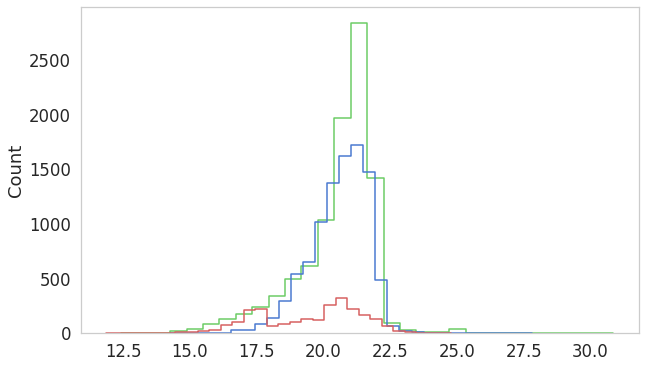

In [241]:
fig, ax1 = plt.subplots(ncols = 1, figsize = (10, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step", fill=False)
sns.histplot(X3_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'b', element="step", fill=False)
sns.histplot(X2_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'r', element="step", fill=False)

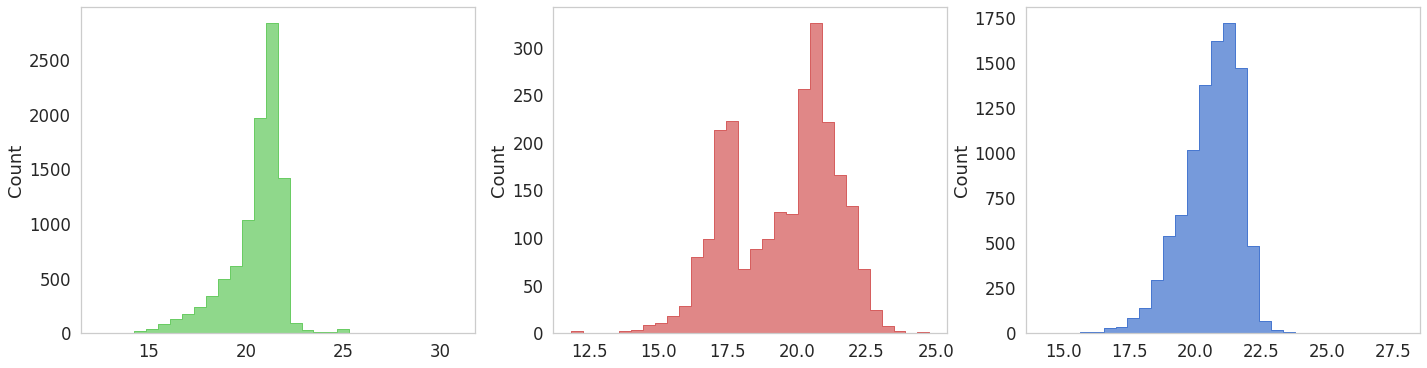

In [242]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train_not_scaling[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train_not_scaling[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

In [243]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21624, 10) (8240, 10) (21624,) (8240,)


Посмотрим, насколько линейно разделимы данные

In [ ]:
from sklearn.manifold import TSNE
idx = np.random.permutation(23653)
x_tmp = TSNE(2).fit_transform(X_train)
x_tmp = x_tmp[idx]
y_tmp = y_train[idx]

In [ ]:
import seaborn as sns

In [ ]:
aaa = (y_tmp != 1)
x_aaa = x_tmp[aaa]
y_aaa = y_tmp[aaa]
bbb = (y_tmp != 0)
x_bbb = x_tmp[bbb]
y_bbb = y_tmp[bbb]

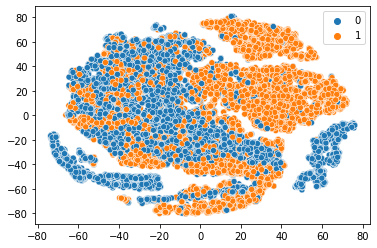

In [ ]:
sns.scatterplot(x=x_tmp[:, 0], y=x_tmp[:, 1], hue=y_tmp)

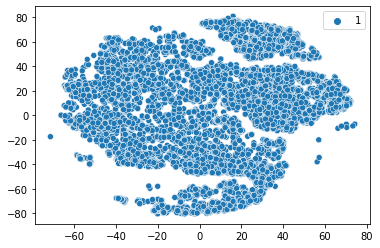

In [ ]:
sns.scatterplot(x=x_bbb[:, 0], y=x_bbb[:, 1], hue=y_bbb)

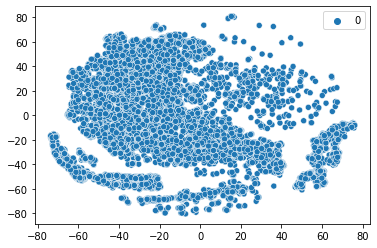

In [ ]:
sns.scatterplot(x=x_aaa[:, 0], y=x_aaa[:, 1], hue=y_aaa)

Будем строить классификатор на основе случайного леса и градиентного бустинга

In [ ]:
! sudo pip install hpsklearn

In [ ]:
! sudo pip show hpsklearn

Дополнительно можно проверить, какой из классификаторов считает наиболее точным HyperoptEstimator, который одновременно с этом подбирает параметры

In [ ]:
from hpsklearn import HyperoptEstimator
from hpsklearn import svc, knn, random_forest, gradient_boosting
from hpsklearn import any_preprocessing
from hyperopt import tpe
from hyperopt import hp

def any_classifier(name):
    classifiers = [
        svc(name + '.svc'),
        knn(name + '.knn'),
        random_forest(name + '.random_forest'),
        gradient_boosting(name + '.grad_boosting', loss='deviance'),
    ]
    return hp.choice('%s' % name, classifiers)

model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, max_evals=50, trial_timeout=30)
model.fit(X_train, y_train)

In [53]:
acc = model.score(X_test, y_test)
print("Accuracy: %.3f" % acc)
print(model.best_model())

Accuracy: 0.848
{'learner': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=260, n_jobs=1,
                       oob_score=False, random_state=3, verbose=False,
                       warm_start=False), 'preprocs': (StandardScaler(copy=True, with_mean=True, with_std=False),), 'ex_preprocs': ()}


Если запустить полученную модель:

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
gbs = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance',
                           max_depth=None, max_features=0.5036239312523166,
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=2,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=120, n_iter_no_change=None, random_state=1,
                           subsample=0.5587628410453255, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
gbs.fit(X_train, y_train)
pred = gbs.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gbs.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gbs.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2747
           1       0.87      0.92      0.89      2746

    accuracy                           0.89      5493
   macro avg       0.89      0.89      0.89      5493
weighted avg       0.89      0.89      0.89      5493

Confusion Matrix: 
 [[2384  363]
 [ 232 2514]]
Training Score:  1.0
Testing Score:  0.8916803204077918


Так же для lightgbm мы можем подбирать параметры с помощью hyperopt таким образом: (каждый раз результат может отличаться, потому что мы не прогоняемся по всей сетке, а предстказываем)

In [ ]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error

lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.001, 0.1, 0.01)),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'num_leaves' :  hp.choice('num_leaves',    np.array([5, 10, 31, 60, 80, 100])),
    'n_estimators':     hp.choice('n_estimators',    np.array([300, 500, 700, 900, 1000, 1500, 2000]))
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def rf_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
obj = HPOpt(X_train, X_test, y_train, y_test)

lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=1000)

In [ ]:
lgb_opt

({'colsample_bytree': 4,
  'learning_rate': 2,
  'max_depth': 8,
  'min_child_weight': 2,
  'subsample': 0.9559727725604034},
 <hyperopt.base.Trials at 0x7fee6dc1cb00>)

Так же можно прогонять по сетке (что намного дольше)

In [ ]:
import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV  
gbcv = LGBMClassifier(objective='binary')
parameters = {
    'n_estimators' : [150, 300, 500, 700, 900, 1000, 1500, 2000],
    'num_leaves' :  [5, 10, 31, 60, 80, 100],
    'max_depth' : [1, 2, 3, 5, 10, 20], 
    'learning_rate' : np.linspace(0.001, 0.01, num=7)
       }
cl = GridSearchCV(gbcv, parameters, scoring='f1')
t = time.time() 
cl.fit(X_train, y_train)
print(-t + time.time())
cl.best_params_

In [244]:
from lightgbm import LGBMClassifier
#gb = joblib.load('gb.pkl')
gb = LGBMClassifier(n_estimators=1100, num_leaves=10, learning_rate=0.07, max_depth=13, min_child_weight=2, subsample=0.83, colsample_bytree=0.4)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      4120
           1       0.87      0.91      0.89      4120

    accuracy                           0.88      8240
   macro avg       0.88      0.88      0.88      8240
weighted avg       0.88      0.88      0.88      8240

Confusion Matrix: 
 [[3544  576]
 [ 391 3729]]
Training Score:  0.8984924158342582
Testing Score:  0.8826456310679611


Аналогично работаем с Случайным лесом:

In [ ]:
import time
from sklearn.model_selection import GridSearchCV  
rfcv = RandomForestClassifier(random_state=42) 
parameters = {
    'n_estimators' : [50, 100, 150, 200, 250, 300, 500, 1000],
    "max_features" : [1, 3, 4, 5, 10, 20, 30],
    'min_samples_leaf': [1, 3, 5, 7, 10, 14]
       }
cl = GridSearchCV(rfcv, parameters, scoring='f1')
t = time.time() 
cl.fit(X_train, y_train)
cl.best_params_

In [ ]:
def any_classifier(name):
    classifiers = [
        svc(name + '.svc'),
        knn(name + '.knn'),
        random_forest(name + '.random_forest'),
        #gradient_boosting(name + '.grad_boosting', loss='deviance'),
    ]
    return hp.choice('%s' % name, classifiers)

model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, max_evals=50, trial_timeout=30)
model.fit(X_train, y_train)

In [ ]:
acc = model.score(X_test, y_test)
print("Accuracy: %.3f" % acc)
print(model.best_model())

In [56]:
rfs = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=260, n_jobs=1,
                       oob_score=False, random_state=3, verbose=False,
                       warm_start=False)
rfs.fit(X_train, y_train)
pred = rfs.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
rf_train_acc = rfs.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rfs.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2747
           1       0.88      0.92      0.90      2746

    accuracy                           0.90      5493
   macro avg       0.90      0.90      0.90      5493
weighted avg       0.90      0.90      0.90      5493

Confusion Matrix: 
 [[2397  350]
 [ 226 2520]]
Training Score:  0.920004855547463
Testing Score:  0.8951392681594756


In [245]:
import time
t = time.time()
rf = RandomForestClassifier(n_estimators=900, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)
print(-t + time.time())

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      4120
           1       0.86      0.91      0.89      4120

    accuracy                           0.88      8240
   macro avg       0.88      0.88      0.88      8240
weighted avg       0.88      0.88      0.88      8240

Confusion Matrix: 
 [[3528  592]
 [ 375 3745]]
Training Score:  1.0
Testing Score:  0.8826456310679611
112.10619068145752


In [ ]:
rf.feature_importances_

array([0.21802921, 0.14122197, 0.06721733, 0.05923266, 0.09607719,
       0.100812  , 0.08522348, 0.05596358, 0.07053367, 0.10568891])

In [ ]:
joblib.dump(gb, 'gb.pkl')
gb.feature_importances_

array([9269, 6904, 5666, 4796, 5856, 5533, 4367, 4142, 4093, 5342])

# Построение графиков

Построим для классификатора OB против квазаров и галактик

In [204]:
def roc(model, X_test, y_test, lab):
    from sklearn.metrics import roc_curve
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=lab)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show() 

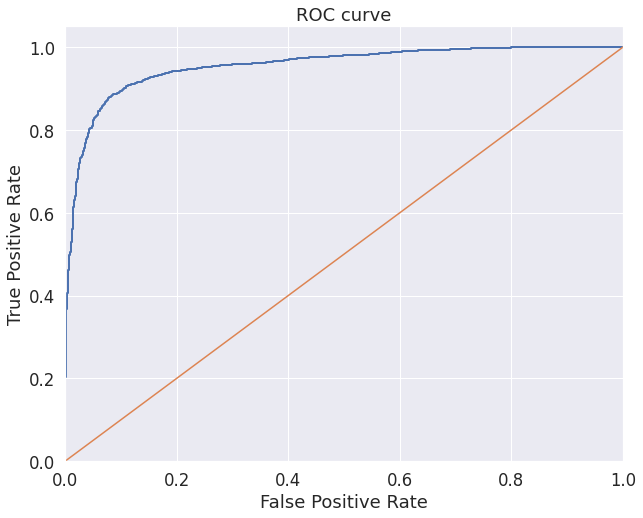

In [205]:
roc(gbs, X_test, y_test, 1)

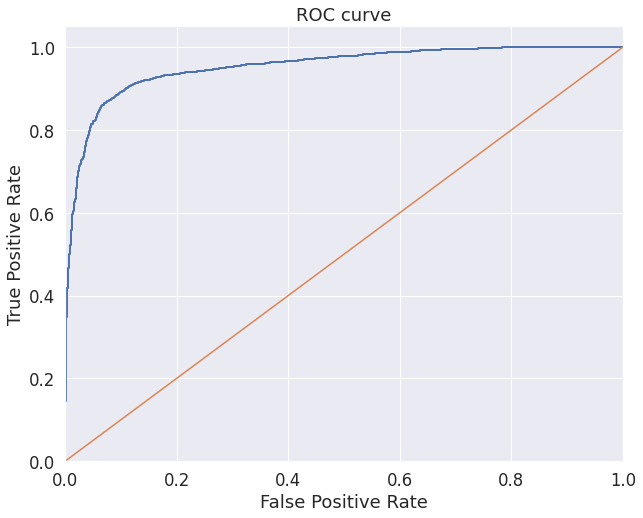

In [206]:
roc(gb, X_test, y_test, 1)

In [207]:
def roc3D(ml, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling):
    from sklearn.metrics import roc_curve, auc
    
    X_test_not_scaling = X0_test_not_scaling[X0_test_not_scaling[:,7].argsort()]
    X_test = X0_test[X0_test_not_scaling[:,7].argsort()]
    y_test = y0_test[X0_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 15
    shift = len(y_test)//n
    fpr = []
    tpr = []
    r_mean = []
    AUC = []
    r = []
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]
            X = X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((X2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            y = y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((y2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            ind = np.random.choice(len(y), size=shift, replace=False)
            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y[ind]))
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X[ind])))
            f, t, thresholds = roc_curve(yt, yp[:,1], pos_label=1)
            fpr = np.concatenate((fpr, f))
            tpr = np.concatenate((tpr, t))
            r.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            AUC.append(auc(f, t))
            r_mean = np.concatenate((r_mean, [X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean()]*len(f)))
    return fpr, tpr, r_mean, AUC, r



2124 2124 2124


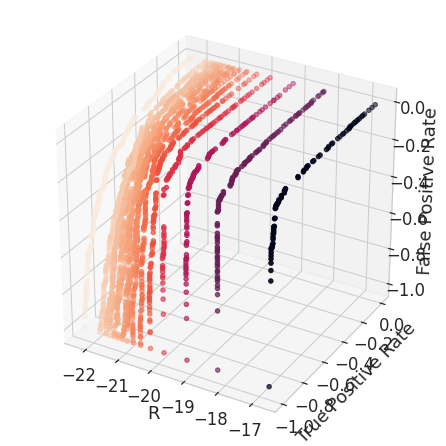

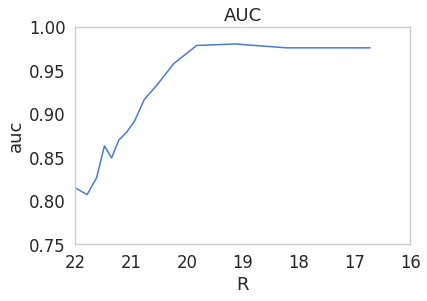

In [223]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) 
x, y, z, auc, r = roc3D(rf, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling)

print(len(x), len(y), len(z))
ax.scatter(-z, -y, -x, c=z, marker='o')
ax.set_xlabel('R')
ax.set_ylabel('True Positive Rate')
ax.set_zlabel('False Positive Rate')

plt.show()

plt.figure()
plt.title('AUC')
plt.plot(r, auc, 'b')
plt.plot([0,1],[0,1],'r--')
plt.ylim([0.75, 1])
plt.xlim([22,16])
plt.ylabel('auc')
plt.xlabel('R')
plt.show()

In [220]:
def prec_rec(ml, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    X_test_not_scaling = X0_test_not_scaling[X0_test_not_scaling[:,7].argsort()]
    X_test = X0_test[X0_test_not_scaling[:,7].argsort()]
    y_test = y0_test[X0_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 14
    shift = len(y_test)//n

    plt.figure(figsize=(10, 10))
    lines = []
    labels = []
    AP = []
    r = []
    clr = ['mediumorchid', 'blueviolet', 'royalblue', 'navy', 'darkslategrey', 'limegreen', 'lightgreen', 'greenyellow', 'yellow', 'orange', 'coral', 'r', 'magenta', 'black']
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)
    j = 0

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]
            X = X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((X2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            y = y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((y2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            ind = np.random.choice(len(y), size=shift, replace=False)
            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y[ind]))
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X[ind])))

            f, t, thresholds = precision_recall_curve(yt, yp[:,1], pos_label=1)
            l, = plt.plot(t, f, color=clr[j], lw=2)
            j+=1
            lines.append(l)
            r1 = X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean()
            labels.append('r = ' + str(r1))
            r.append(r1)
            AP.append(average_precision_score(yt, yp[:,1]))
            
    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    #plt.xlim([15, 23])
    #plt.ylim([0.4, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Recall curve to multi-class')
    plt.legend(lines, labels, loc=(0, -0.75), prop=dict(size=14))
    plt.show()

    plt.figure()
    plt.title('AP')
    plt.plot(r, AP, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.ylim([0.75, 1])
    plt.xlim([22,16])
    plt.ylabel('AP')
    plt.xlabel('R')
    plt.show()

   # return fpr, tpr, r_mean, AUC, r

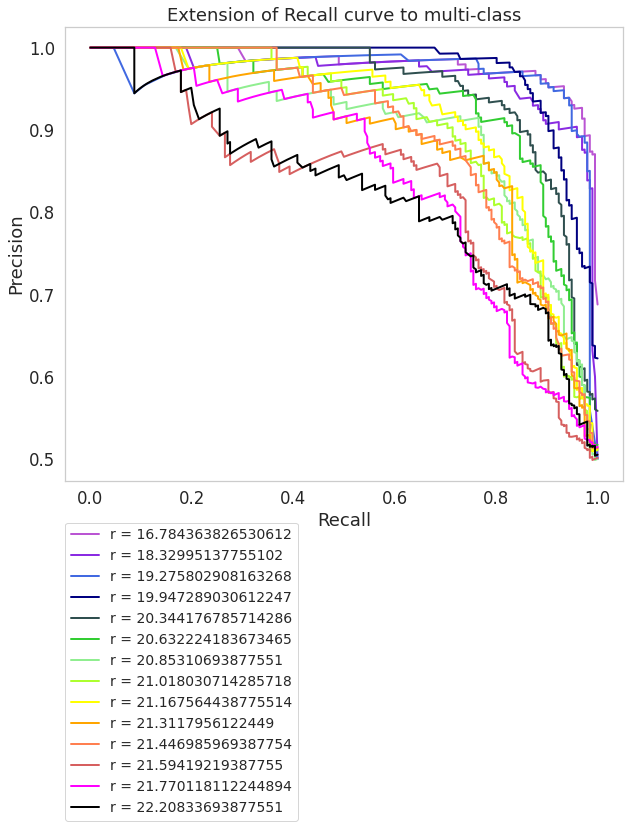

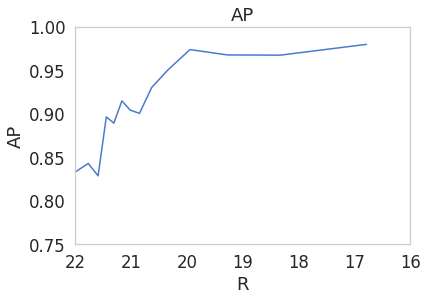

In [221]:
prec_rec(rf, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling)

In [211]:
def prec_rec3D(ml, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    X_test_not_scaling = X0_test_not_scaling[X0_test_not_scaling[:,7].argsort()]
    X_test = X0_test[X0_test_not_scaling[:,7].argsort()]
    y_test = y0_test[X0_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 15
    shift = len(y_test)//n
    Precision = []
    Recall = []
    r_mean = []
    AP = []
    r = []
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]
            X = X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((X2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            y = y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((y2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            ind = np.random.choice(len(y), size=shift, replace=False)
            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y[ind]))
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X[ind])))
            f, t, thresholds = precision_recall_curve(yt, yp[:,1], pos_label=1)
            Precision = np.concatenate((Precision, f))
            Recall = np.concatenate((Recall, t))
            AP.append(average_precision_score(yt, yp[:,1]))
            r.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            
            r_mean = np.concatenate((r_mean, [X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean()]*len(f)))
    return Precision, Recall, r_mean,  AP, r

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) 
x, y, z, AP, r = prec_rec(gb, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling)

print(len(x), len(y), len(z))
ax.scatter(z, y, x, c=z, marker='o')
ax.set_xlabel('cModelMag_r')
ax.set_ylabel('Recall')
ax.set_zlabel('Precision')

plt.show()


#Функции проверки полноты при фиксированной точности 

In [224]:
def THRESHOLD (yt, sp, p):
    t = 0
    maxt = np.zeros(2) #maxt[0] = pr max, maxt[1] = THRESHOLD max
    for THRESHOLD in np.arange(0.1, 1.01, 0.01).astype('float32'):
        #print(yt.shape)
        pred = (sp[:, 1] > (1 - THRESHOLD))*1
        #print(len(pred))
        TP = (pred == yt)[sp[:, 0] >= THRESHOLD].sum()
        FN = (pred != yt)[sp[:, 0] >= THRESHOLD].sum()
        FP = (pred != yt)[sp[:, 1] >= THRESHOLD].sum()
        TN = (pred == yt)[sp[:, 1] >= THRESHOLD].sum()
        pr = TP/(TP+FP)
        #print(THRESHOLD, pr)
        if pr >= p and pr!=1.0:
            t = THRESHOLD
            break
        #if pr > maxt[0] and pr!=1.0:
        #    maxt[0] = pr
        #    maxt[1] = THRESHOLD
    return t

In [225]:
def precis(yt, sp, THRESHOLD):
        pred = (sp[:, 1] > (1 - THRESHOLD))*1
        TP = (pred == yt)[sp[:, 0] >= THRESHOLD].sum()
        FN = (pred != yt)[sp[:, 0] >= THRESHOLD].sum()
        FP = (pred != yt)[sp[:, 1] >= THRESHOLD].sum()
        TN = (pred == yt)[sp[:, 1] >= THRESHOLD].sum()
        return TP/(TP+FP)
        

In [226]:
def recal(yt, sp, THRESHOLD):
        pred = (sp[:, 1] > (1 - THRESHOLD))*1
        TP = (pred == yt)[sp[:, 0] >= THRESHOLD].sum()
        FN = (pred != yt)[sp[:, 0] >= THRESHOLD].sum()
        FP = (pred != yt)[sp[:, 1] >= THRESHOLD].sum()
        TN = (pred == yt)[sp[:, 1] >= THRESHOLD].sum()
        return TP/(TP+FN)

In [250]:
def print_plot(ml, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling, name, prec=0.8):
    
    X_test_not_scaling = X0_test_not_scaling[X0_test_not_scaling[:,7].argsort()]
    X_test = X0_test[X0_test_not_scaling[:,7].argsort()]
    y_test = y0_test[X0_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 20
    shift = len(y_test)//n
    print(shift)
    precision = []
    recall = []
    f1 = []
    r_mean = []
    threshold = []
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]
            X = np.concatenate((X2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            y = np.concatenate((y2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            ind = np.random.choice(len(y), size=shift, replace=False)
            
            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y[ind]))
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X[ind])))
            p = THRESHOLD(yt, yp, prec)
            if p > 0:
                recall.append(recal(yt, yp, p))
                precision.append(precis(yt, yp, p))
                threshold.append(p)
                r_mean.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            
    #plt.title('Зависимость recall от признкака cModelMag_r:'+name)
    #plt.plot(r_mean, recall, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    #plt.figure(figsize = (5,4))
    
    return precision, recall, threshold, r_mean

In [ ]:
test_precision = []
test_threshold = []
test_recall = []
#plt.figure(figsize = (5,4))

for i in range(50):
    precision, recall, threshold, r_mean = print_plot(rf, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling, 'OB', 0.8)
   # plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.8 для rf:')
    #plt.plot(r_mean, recall, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    #plt.figure(figsize = (5,4))
    test_precision.append(precision)
    test_recall.append(recall)
    test_threshold.append(threshold)


<Figure size 360x288 with 0 Axes>

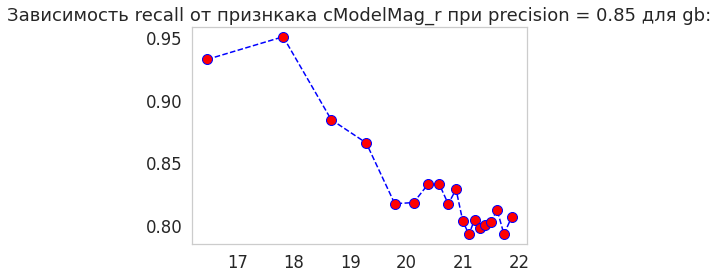

<Figure size 360x288 with 0 Axes>

In [254]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.85 для gb:')
plt.plot(r_mean[:-1], np.mean(test_recall, axis=0)[:-1], color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

<Figure size 360x288 with 0 Axes>

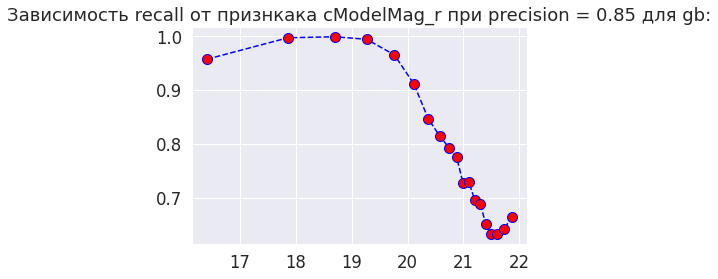

<Figure size 360x288 with 0 Axes>

In [161]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.85 для gb:')
plt.plot(r_mean[:-1], np.mean(test_recall, axis=0)[:-1], color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

<Figure size 360x288 with 0 Axes>

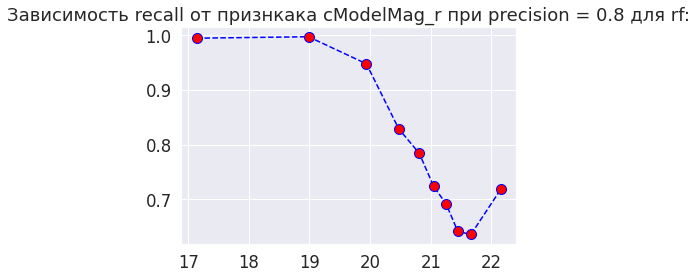

<Figure size 360x288 with 0 Axes>

In [157]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.85 для gb:')
plt.plot(r_mean, np.mean(test_recall, axis=0), color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

<Figure size 360x288 with 0 Axes>

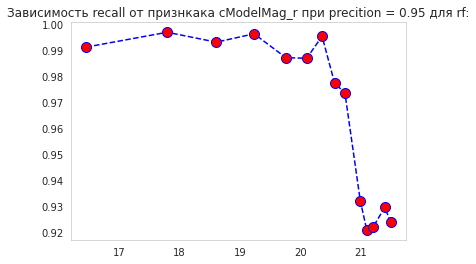

<Figure size 360x288 with 0 Axes>

In [ ]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.95 для rf:')
plt.plot(r_mean, np.mean(test_recall, axis=0), color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

In [ ]:
test_precision = []
test_threshold = []
test_recall = []

for i in range(50):
    precision, recall, threshold, r_mean = print_plot(gb, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling, 'OB', 0.80)
    test_precision.append(precision)
    test_recall.append(recall)
    test_threshold.append(threshold)

<Figure size 360x288 with 0 Axes>

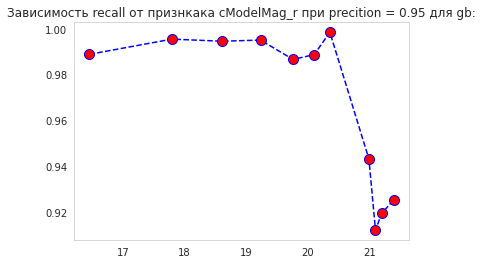

<Figure size 360x288 with 0 Axes>

In [ ]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.95 для gb:')
plt.plot(r_mean, np.mean(test_recall, axis=0), color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

<Figure size 360x288 with 0 Axes>

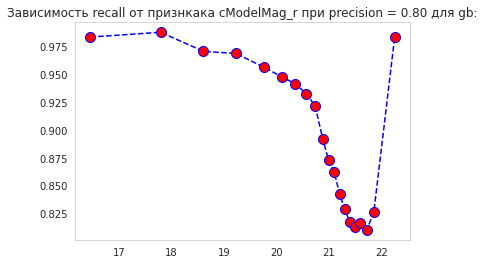

<Figure size 360x288 with 0 Axes>

In [ ]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.80 для gb:')
plt.plot(r_mean, np.mean(test_recall, axis=0), color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

# Построение других классификаторов 

OB против других звезд

In [144]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_test_not_scaling, X1_test_not_scaling, X0_train_not_scaling, X1_train_not_scaling, X0_train, X0_test, y0_train, y0_test, X1_train, X1_test, y1_train, y1_test = data_preparation_st(X_st, y_st, 0.5)

pacanьё 367866
pacanьё 93480
pacanьё 34472
pacanьё 179953
pacanьё 152959
pacanьё 95455
pacanьё 7996
pacanьё 14451


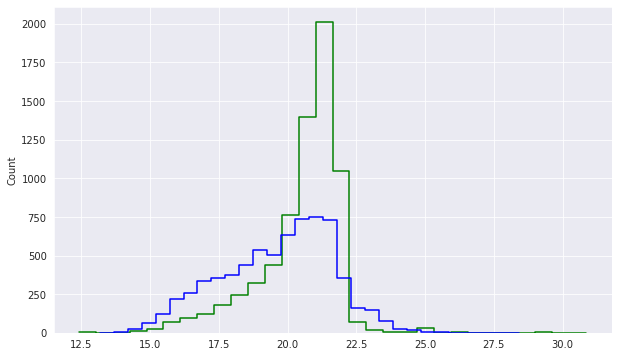

In [145]:
fig, ax1 = plt.subplots(ncols = 1, figsize = (10, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step", fill=False)
sns.histplot(X1_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'b', element="step", fill=False)

In [146]:
import time
t = time.time()
rf = RandomForestClassifier(n_estimators=700, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)
print(-t + time.time())

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      6866
           1       0.86      0.79      0.82      6864

    accuracy                           0.83     13730
   macro avg       0.83      0.83      0.83     13730
weighted avg       0.83      0.83      0.83     13730

Confusion Matrix: 
 [[5972  894]
 [1467 5397]]
Training Score:  1.0
Testing Score:  0.828040786598689
53.87161564826965


In [147]:
from lightgbm import LGBMClassifier

gb = LGBMClassifier(n_estimators=900, num_leaves=60, learning_rate=0.01, max_depth=15)#, is_unbalance=True)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      6866
           1       0.86      0.78      0.82      6864

    accuracy                           0.82     13730
   macro avg       0.83      0.82      0.82     13730
weighted avg       0.83      0.82      0.82     13730

Confusion Matrix: 
 [[5976  890]
 [1527 5337]]
Training Score:  0.8809090246922573
Testing Score:  0.8239621267297887


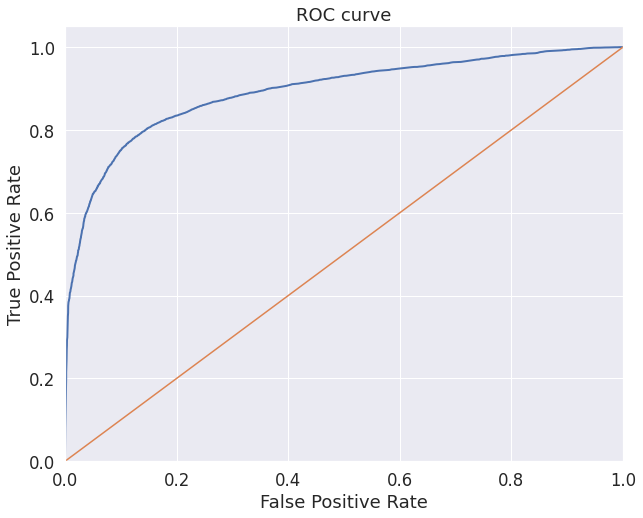

In [148]:
roc(rf, X_test, y_test, 1)

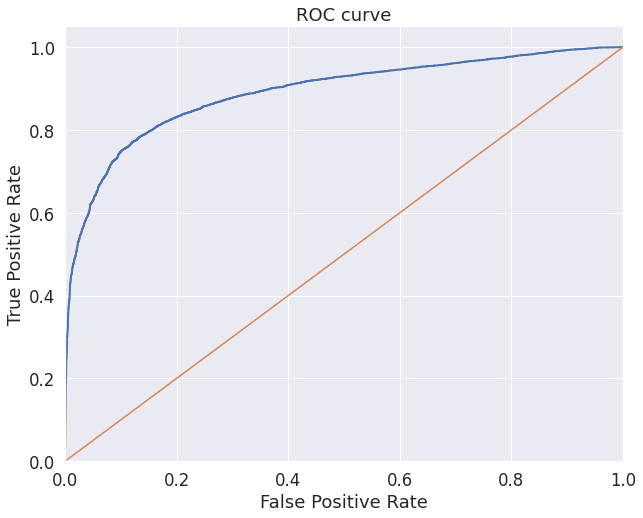

In [149]:
roc(gb, X_test, y_test, 1)

# Дополнительно

Разделение на спекральные классы:


In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (100, 6))
sns.countplot(x=df[df['class']=='STAR']['subClass'], palette = 'magma')

In [ ]:
df[df['class']=='STAR']['subClass'].value_counts()

In [ ]:
sub_class_val = df[df['class'] == 'STAR']['subClass'].value_counts()
sub_class_val

In [ ]:
def renameSubClass(a, a_str):
    for i in range(len(a)):
        labels = {a[i]: a_str}
        df.replace({'subClass':labels}, inplace = True)

In [ ]:
sub_class = df_star['subClass'].unique()
sub_class_val[sub_class[[i for i in range(len(sub_class)) if 'O' in sub_class[i]]]].sum()

In [ ]:
OB = sub_class[[i for i in range(len(sub_class)) if 'O' in sub_class[i]or 'B' in sub_class[i]]]
renameSubClass(OB, 'OB')
M = sub_class[[i for i in range(len(sub_class)) if 'M' in sub_class[i]]]
renameSubClass(M, 'M')
A = sub_class[[i for i in range(len(sub_class)) if 'A' in sub_class[i]]]
renameSubClass(A, 'A')
F = sub_class[[i for i in range(len(sub_class)) if 'F' in sub_class[i]]]
renameSubClass(F, 'F')
K = sub_class[[i for i in range(len(sub_class)) if 'K' in sub_class[i]]]
renameSubClass(K, 'K')
G = sub_class[[i for i in range(len(sub_class)) if 'G' in sub_class[i]]]
renameSubClass(G, 'G')
LT = sub_class[[i for i in range(len(sub_class)) if 'L' in sub_class[i] or 'T' in sub_class[i]]]
renameSubClass(LT, 'LT')
WD = sub_class[[i for i in range(len(sub_class)) if 'WD' in sub_class[i]]]
renameSubClass(WD, 'WD')
C = sub_class[[i for i in range(len(sub_class)) if 'C' in sub_class[i]]]
renameSubClass(C, 'C')
sns.set_style('darkgrid')
plt.figure(figsize = (100, 6))
sns.countplot(x=df['subClass'], palette = 'magma')

Поверка на данных с измененным поглощением: 

In [ ]:
coeff = {'u': 4.239, 'g': 3.303, 'r': 2.285, 'i': 1.698, 'z': 1.263} #Rv = 3.1

In [ ]:
df[(df['z'] == 0) & (df['class'] == 2)].shape

(0, 17)

In [ ]:
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
3485413,1237661001056845889,156.85147,41.638954,0.364095,0.000102,2,NaN,17.14206,17.57845,17.73233,18.68621,17.40770,10.48924,10.43573,10.56004,11.62111,10.30533
4220713,1237661001056845889,156.85147,41.638954,0.290089,0.000045,2,NaN,17.14206,17.57845,17.73233,18.68621,17.40770,10.48924,10.43573,10.56004,11.62111,10.30533
2278661,1237661974938976281,190.48903,6.850845,-0.000051,0.000524,1,WD,17.50879,18.56535,18.63430,19.23723,19.02882,10.20505,10.71276,10.84706,11.03211,10.64249
751942,1237661948639772687,175.24482,11.471141,0.003304,0.000008,2,BROADLINE,17.75602,16.17859,15.55491,15.16904,14.55951,12.90137,11.70385,11.03817,10.66695,10.37867
1607931,1237663203863035998,51.70502,-0.007240,-0.000004,0.000025,1,K5,21.05164,20.39033,18.83824,18.56721,18.00602,14.23634,13.96546,11.05246,10.99057,10.27308


In [ ]:
def extinction(X, Ebv):

    for Mag in [5, 10]:
        for i, filters in enumerate(['u', 'g', 'r', 'i', 'z']):
            X[:, Mag+i] = X[:, Mag+i] + float(Ebv * coeff[filters])
    return X


In [ ]:
def Acc(Model, X_main, y, index):
    
    #train_acc = []
    test_acc = []
    #train_f1 = []
    test_f1 = []
    
    EBV = np.arange(0, 3, 0.25)
    
    for Ebv in tqdm(EBV):
        X = X_main.copy()
        X[index] = extinction(X[index], Ebv)
        X_test = robust.transform(X)
        
        #print(X_train.shape)

        #train_ans = Model.predict(X_train)
        test_ans = Model.predict(X_test)
        #train_acc.append(accuracy_score(y, train_ans))
        #train_f1.append(classification_report(y_train, train_ans, output_dict=True, zero_division=0)['1']['f1-score'])
        test_acc.append(accuracy_score(y, test_ans))
        test_f1.append(classification_report(y, test_ans, output_dict=True, zero_division=0)['1']['f1-score'])
    
    return test_acc, test_acc, test_f1, test_f1, EBV


[0.9739966275577628, 0.9740793678731154, 0.9741973609001894, 0.9742802511422893, 0.9742926572780627, 0.9743409426720633, 0.974347200142803, 0.974372580907149, 0.9743695343182488, 0.9743144482767335, 0.9742231143893064, 0.9741187248028671] [0.9739966275577628, 0.9740793678731154, 0.9741973609001894, 0.9742802511422893, 0.9742926572780627, 0.9743409426720633, 0.974347200142803, 0.974372580907149, 0.9743695343182488, 0.9743144482767335, 0.9742231143893064, 0.9741187248028671] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9630814967492092 with 0.0 Ebv


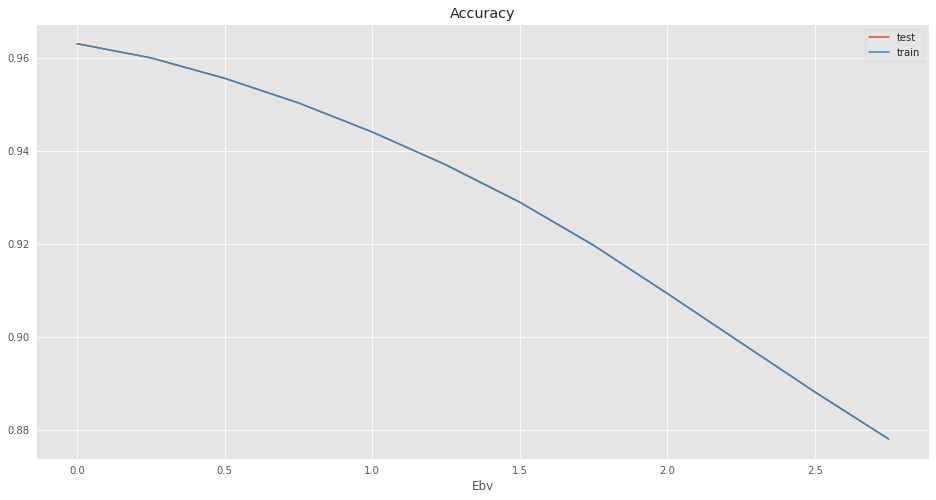

Лучший f1_score  0.974372580907149 with 1.75 Ebv


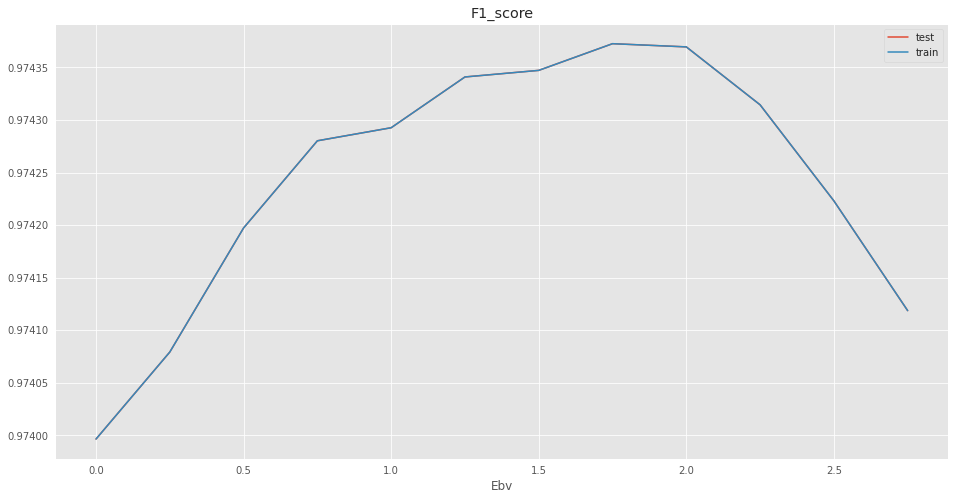

In [ ]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(lr, X_test_not_scaling, y_test, y_test==y_test)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.9739966275577628, 0.9737460138230434, 0.9734820427626638, 0.9732046938536001, 0.9729000331541462, 0.9726071235931276, 0.9723040979453801, 0.9720174847950586, 0.971704150578839, 0.9713600596377421, 0.9709871453201779, 0.970620615023198] [0.9739966275577628, 0.9737460138230434, 0.9734820427626638, 0.9732046938536001, 0.9729000331541462, 0.9726071235931276, 0.9723040979453801, 0.9720174847950586, 0.971704150578839, 0.9713600596377421, 0.9709871453201779, 0.970620615023198] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9630814967492092 with 0.0 Ebv


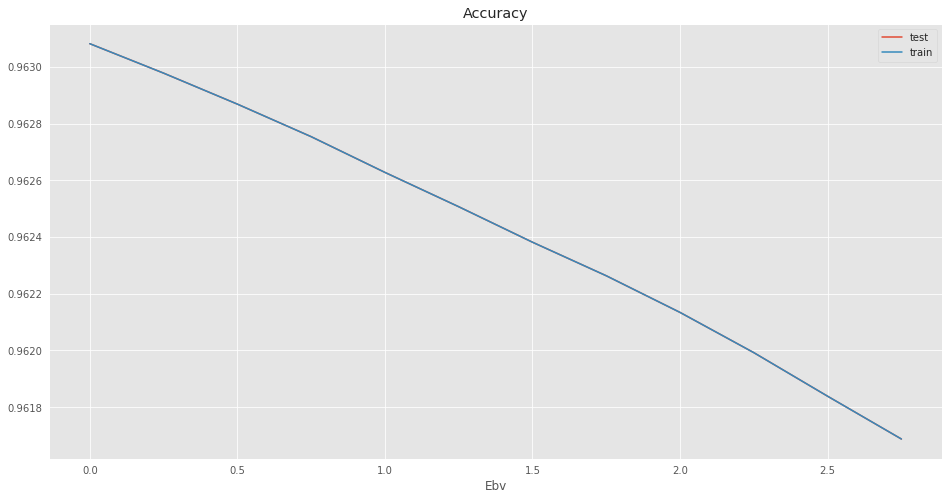

Лучший f1_score  0.9739966275577628 with 0.0 Ebv


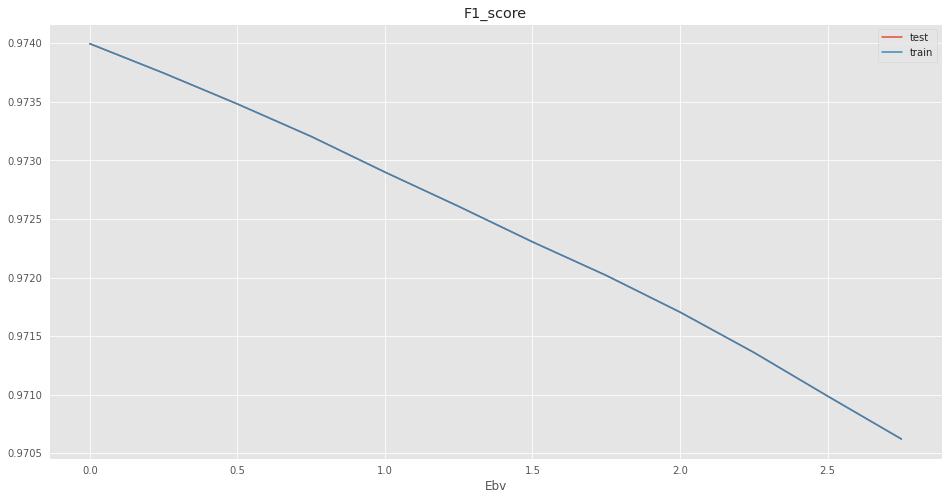

In [ ]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(lr, X_test_not_scaling, y_test, y_test==1)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.008360714588592522, 0.007972285177915662, 0.007572194615484264, 0.007257044146167388, 0.006940665864543338, 0.006616474484789009, 0.006307482753176592, 0.005995770475050983, 0.005722376449708154, 0.005465341362993916, 0.005199363369402662, 0.004953851635668245] [0.008360714588592522, 0.007972285177915662, 0.007572194615484264, 0.007257044146167388, 0.006940665864543338, 0.006616474484789009, 0.006307482753176592, 0.005995770475050983, 0.005722376449708154, 0.005465341362993916, 0.005199363369402662, 0.004953851635668245] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.00418836126213034 with 0.0 Ebv


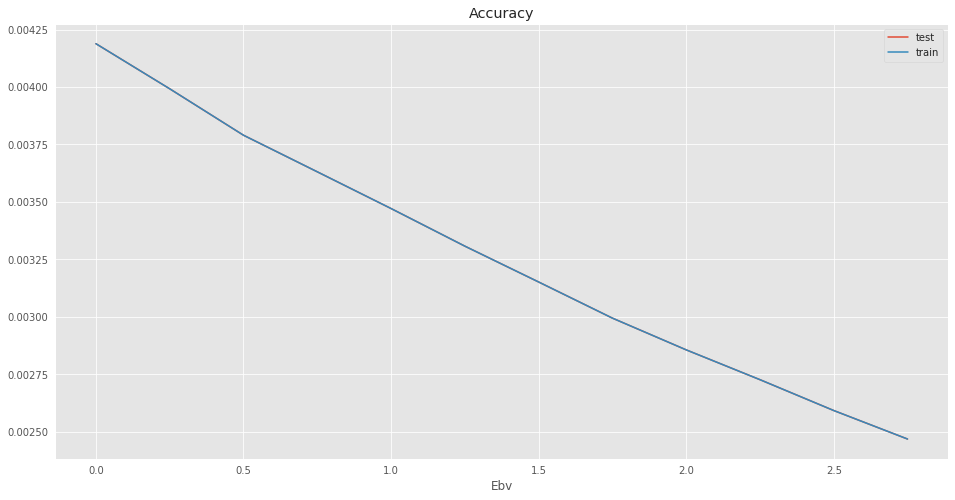

Лучший f1_score  0.008360714588592522 with 0.0 Ebv


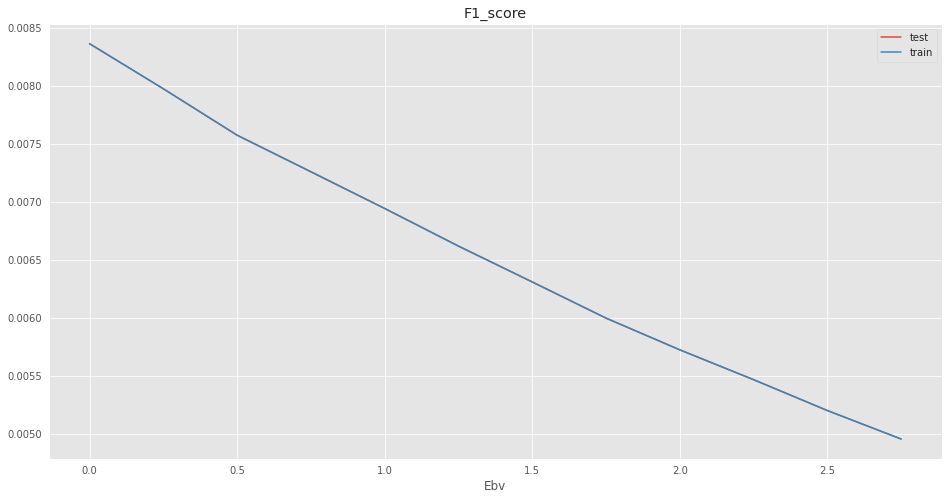

In [ ]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(lr2, X2_test_not_scaling, y2_test, y2_test==y2_test)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.9978232533467885, 0.9976728422370725, 0.9974940876636037, 0.9973314814707048, 0.9972282010979867, 0.9971384311413172, 0.997076295623883, 0.9970263285341202, 0.99695364640959, 0.9968751131736744, 0.9967329794438369, 0.9964635825345232] [0.9978232533467885, 0.9976728422370725, 0.9974940876636037, 0.9973314814707048, 0.9972282010979867, 0.9971384311413172, 0.997076295623883, 0.9970263285341202, 0.99695364640959, 0.9968751131736744, 0.9967329794438369, 0.9964635825345232] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9877626465429579 with 0.0 Ebv


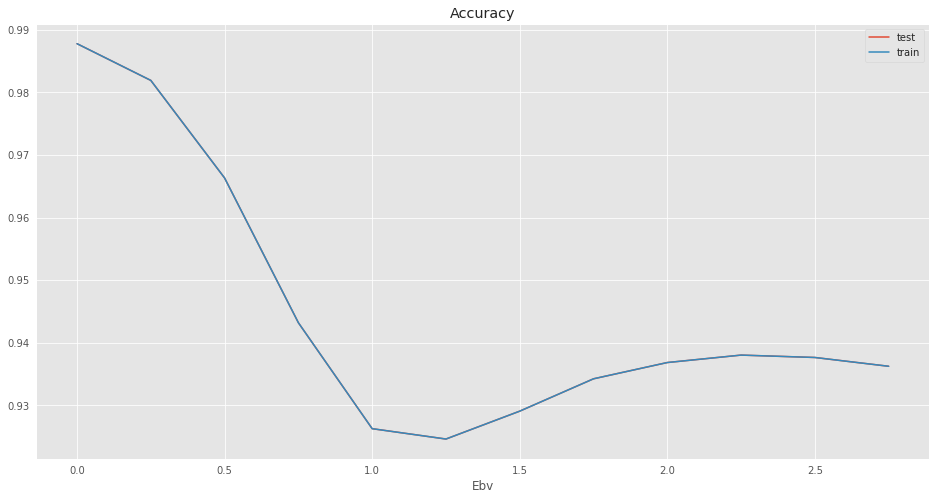

Лучший f1_score  0.9978232533467885 with 0.0 Ebv


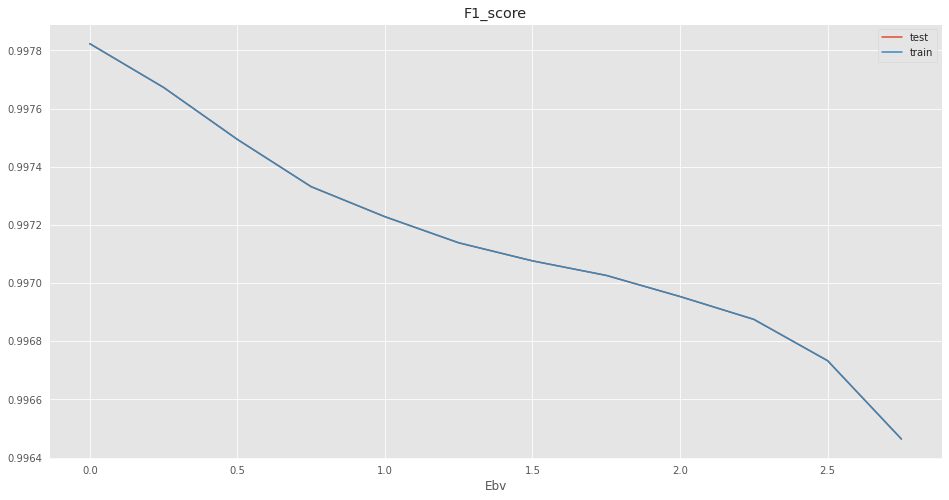

In [ ]:
#dfs = df.sample(1000)
test_acc, train_acc, test_f1, train_f1, grid = Acc(rf, X_test_not_scaling, y_test, y_test==y_test)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.9978232533467885, 0.9978148255482989, 0.9978063976080613, 0.9977921346170391, 0.9977720360769721, 0.9977448045109085, 0.9977020090599846, 0.9976462398066267, 0.9975664660181988, 0.997480840996611, 0.997332259851611, 0.9970596384559413] [0.9978232533467885, 0.9978148255482989, 0.9978063976080613, 0.9977921346170391, 0.9977720360769721, 0.9977448045109085, 0.9977020090599846, 0.9976462398066267, 0.9975664660181988, 0.997480840996611, 0.997332259851611, 0.9970596384559413] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9877626465429579 with 0.0 Ebv


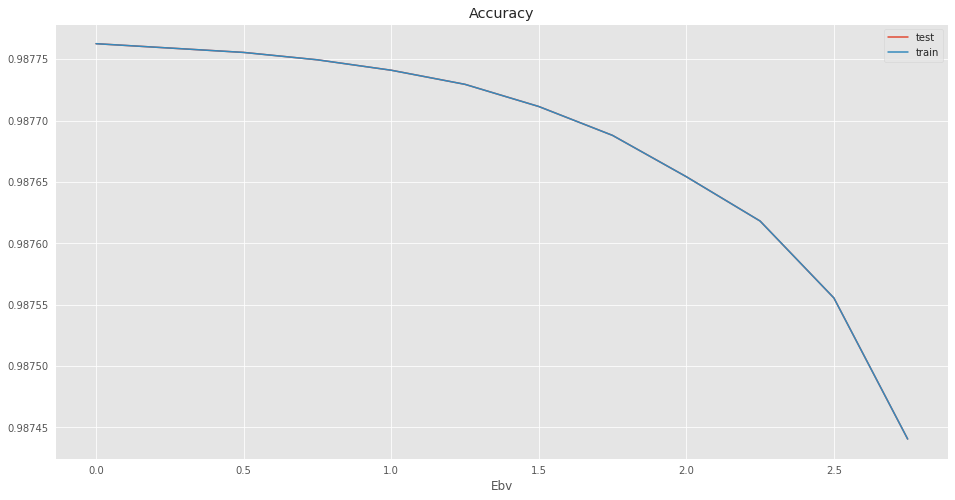

Лучший f1_score  0.9978232533467885 with 0.0 Ebv


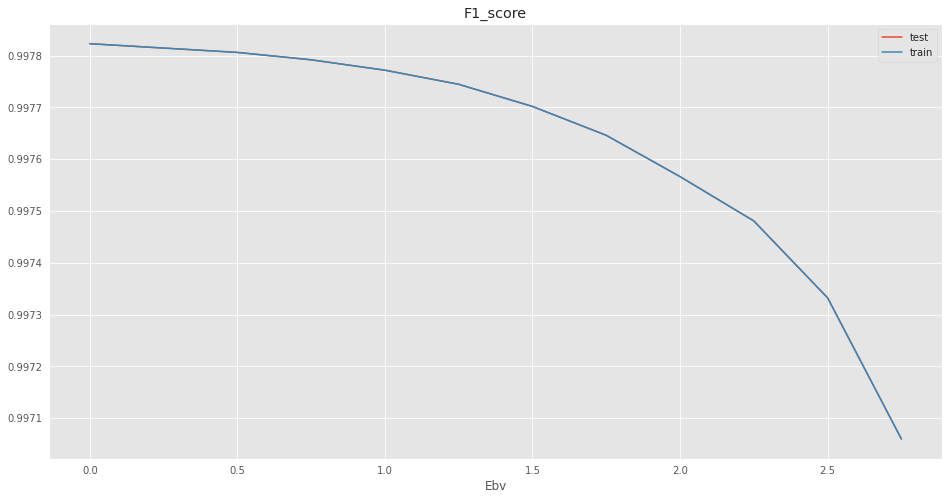

In [ ]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(rf, X_test_not_scaling, y_test, y_test==1)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")


[0.9995309707284386, 0.9995013552596479, 0.9994713396350946, 0.9994372679439766, 0.9994076638806731, 0.9993460573093805, 0.9992872971046748, 0.9992358499476852, 0.9990394233621965, 0.9986006937382867, 0.997840312679004, 0.9964869670114478] [0.9995309707284386, 0.9995013552596479, 0.9994713396350946, 0.9994372679439766, 0.9994076638806731, 0.9993460573093805, 0.9992872971046748, 0.9992358499476852, 0.9990394233621965, 0.9986006937382867, 0.997840312679004, 0.9964869670114478] [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75]
Best accuracy_store is 0.9992608398443739 with 0.0 Ebv


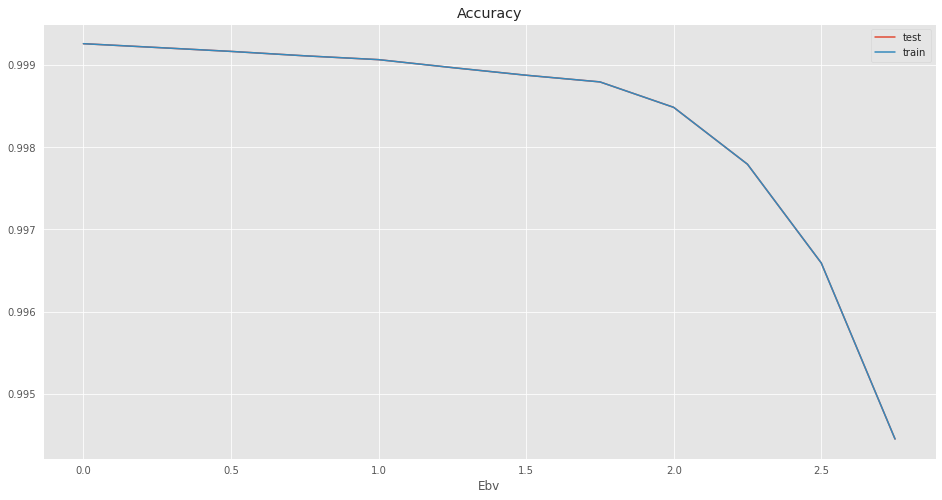

Лучший f1_score  0.9995309707284386 with 0.0 Ebv


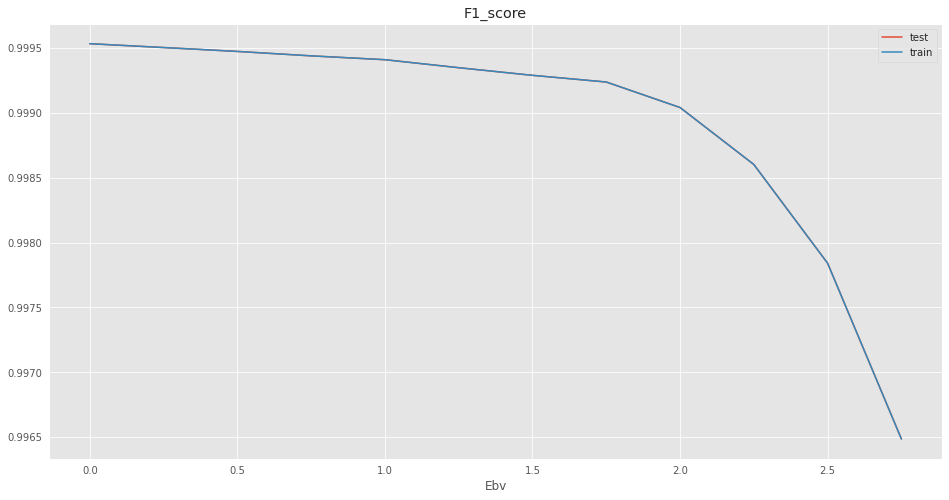

In [ ]:
test_acc, train_acc, test_f1, train_f1, grid = Acc(rf2, X2_test_not_scaling, y2_test, y2_test==y2_test)
print(test_f1, train_f1, grid)
visualize(test_acc, train_acc, test_f1, train_f1, grid, "Ebv")